## Data Handling and Train-Test Split

In [5]:
import os
import pandas as pd
import shutil

In [4]:
root_dir = '/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/'
orig_images_folder = '/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/images'
new_images_folder = '/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images'

In [4]:
data_dir = os.path.join(root_dir,orig_images_folder)
new_data_dir = os.path.join(root_dir,new_images_folder)

In [5]:
image_fnames = pd.read_csv(filepath_or_buffer=os.path.join(root_dir,'images.txt'), 
                          header=None, 
                          delimiter=' ', 
                          names=['Img ID', 'file path'])

In [6]:
image_fnames.tail()

,Img ID,file path
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...
11787,11788,200.Common_Yellowthroat/Common_Yellowthroat_00...


In [7]:
image_fnames.shape

(11788, 2)

In [8]:
image_fnames['is training image?'] = pd.read_csv(filepath_or_buffer=os.path.join(root_dir,'train_test_split.txt'), 
                                                 header=None, delimiter=' ', 
                                                 names=['Img ID','is training image?'])['is training image?']

In [9]:
image_fnames.head()

,Img ID,file path,is training image?
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1


In [10]:
image_fnames.shape

(11788, 3)

In [11]:
training_size = 1000
testing_size = 200
train_count = 0
test_count = 0

In [63]:
for i_image, image_fname in enumerate(image_fnames['file path']):
    if image_fnames['is training image?'].iloc[i_image] and train_count <= training_size:
        train_count = train_count + 1
        new_dir = os.path.join(new_data_dir,'train',image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir,image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))
        print(i_image, ':: Image is in training set. [', bool(image_fnames['is training image?'].iloc[i_image]),']')
        print('Image:: ', image_fname)
        print('Destination:: ', new_dir)
    elif test_count <= testing_size:
        test_count = test_count + 1
        new_dir = os.path.join(new_data_dir,'test',image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        print(data_dir)
        shutil.copy(src=os.path.join(data_dir,image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))
        print(i_image, ':: Image is in testing set. [', bool(image_fnames['is training image?'].iloc[i_image]),']')
        print('Source Image:: ', image_fname)
        print('Destination:: ', new_dir)

/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/images
0 :: Image is in testing set. [ False ]
Source Image::  001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Destination::  /content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images/test/001.Black_footed_Albatross
1 :: Image is in training set. [ True ]
Image::  001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg
Destination::  /content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images/train/001.Black_footed_Albatross
/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/images
2 :: Image is in testing set. [ False ]
Source Image::  001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
Destination::  /content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images/test/001.Black_footed_Albatross
3 :: Image is in training set. [ True ]
Image::  001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg
Destination::  /content/drive/My Drive

## Model


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import time
import copy
import pickle

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

In [3]:
model_name = 'resnet152'
model_func = models.resnet152
data_dir = os.path.join(root_dir,'new_images')
model_dir = os.path.join('models/classification', model_name)
batch_size = 16
num_workers = 4
num_epochs = 20

NameError: ignored

In [14]:
os.makedirs(model_dir, exist_ok=True)

In [15]:
def makeDefaultTransforms(crop_size=224, resize=256):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'test': transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    return data_transforms

In [16]:
data_transforms = makeDefaultTransforms()

In [17]:
data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(data[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'test']}

In [18]:
data['train']

Dataset ImageFolder
    Number of datapoints: 1001
    Root location: /content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [19]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f5a8868d908>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f5a8868d198>}

In [20]:
train_dir = (os.path.join(data_dir, 'train'))

folders = ([name for name in os.listdir(train_dir)
            if os.path.isdir(os.path.join(train_dir, name))])

In [21]:
folders

['001.Black_footed_Albatross',
 '002.Laysan_Albatross',
 '003.Sooty_Albatross',
 '004.Groove_billed_Ani',
 '005.Crested_Auklet',
 '006.Least_Auklet',
 '007.Parakeet_Auklet',
 '008.Rhinoceros_Auklet',
 '009.Brewer_Blackbird',
 '010.Red_winged_Blackbird',
 '011.Rusty_Blackbird',
 '012.Yellow_headed_Blackbird',
 '013.Bobolink',
 '014.Indigo_Bunting',
 '015.Lazuli_Bunting',
 '016.Painted_Bunting',
 '017.Cardinal',
 '018.Spotted_Catbird',
 '019.Gray_Catbird',
 '020.Yellow_breasted_Chat',
 '021.Eastern_Towhee',
 '022.Chuck_will_Widow',
 '023.Brandt_Cormorant',
 '024.Red_faced_Cormorant',
 '025.Pelagic_Cormorant',
 '026.Bronzed_Cowbird',
 '027.Shiny_Cowbird',
 '028.Brown_Creeper',
 '029.American_Crow',
 '030.Fish_Crow',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '033.Yellow_billed_Cuckoo',
 '034.Gray_crowned_Rosy_Finch']

In [22]:
for folder in folders:
    contents = os.listdir(os.path.join(train_dir,folder)) 
    print(folder,len(contents))

001.Black_footed_Albatross 30
002.Laysan_Albatross 30
003.Sooty_Albatross 30
004.Groove_billed_Ani 30
005.Crested_Auklet 30
006.Least_Auklet 30
007.Parakeet_Auklet 30
008.Rhinoceros_Auklet 30
009.Brewer_Blackbird 30
010.Red_winged_Blackbird 30
011.Rusty_Blackbird 30
012.Yellow_headed_Blackbird 30
013.Bobolink 30
014.Indigo_Bunting 30
015.Lazuli_Bunting 30
016.Painted_Bunting 30
017.Cardinal 30
018.Spotted_Catbird 30
019.Gray_Catbird 30
020.Yellow_breasted_Chat 30
021.Eastern_Towhee 30
022.Chuck_will_Widow 30
023.Brandt_Cormorant 30
024.Red_faced_Cormorant 30
025.Pelagic_Cormorant 30
026.Bronzed_Cowbird 30
027.Shiny_Cowbird 30
028.Brown_Creeper 30
029.American_Crow 30
030.Fish_Crow 30
031.Black_billed_Cuckoo 30
032.Mangrove_Cuckoo 30
033.Yellow_billed_Cuckoo 30
034.Gray_crowned_Rosy_Finch 11


In [23]:
train_dir = (os.path.join(data_dir, 'test'))

folders = ([name for name in os.listdir(train_dir)
            if os.path.isdir(os.path.join(train_dir, name))])
folders

['001.Black_footed_Albatross',
 '002.Laysan_Albatross',
 '003.Sooty_Albatross',
 '004.Groove_billed_Ani',
 '005.Crested_Auklet',
 '006.Least_Auklet',
 '007.Parakeet_Auklet',
 '008.Rhinoceros_Auklet',
 '009.Brewer_Blackbird']

In [24]:
for folder in folders:
    contents = os.listdir(os.path.join(train_dir,folder)) 
    print(folder,len(contents))

001.Black_footed_Albatross 30
002.Laysan_Albatross 30
003.Sooty_Albatross 28
004.Groove_billed_Ani 30
005.Crested_Auklet 14
006.Least_Auklet 11
007.Parakeet_Auklet 23
008.Rhinoceros_Auklet 18
009.Brewer_Blackbird 17


In [25]:
dataset_size = {x: len(data[x]) for x in ['train', 'test']}
target_names = data['train'].classes

In [26]:
for dataset in dataset_size.keys():
    print(dataset,' size:: ', dataset_size[dataset],' images')

print('Number of classes:: ', len(target_names))
for i_class, class_name in enumerate(target_names):
    print(i_class,':: ',class_name)

train  size::  1001  images
test  size::  201  images
Number of classes::  34
0 ::  001.Black_footed_Albatross
1 ::  002.Laysan_Albatross
2 ::  003.Sooty_Albatross
3 ::  004.Groove_billed_Ani
4 ::  005.Crested_Auklet
5 ::  006.Least_Auklet
6 ::  007.Parakeet_Auklet
7 ::  008.Rhinoceros_Auklet
8 ::  009.Brewer_Blackbird
9 ::  010.Red_winged_Blackbird
10 ::  011.Rusty_Blackbird
11 ::  012.Yellow_headed_Blackbird
12 ::  013.Bobolink
13 ::  014.Indigo_Bunting
14 ::  015.Lazuli_Bunting
15 ::  016.Painted_Bunting
16 ::  017.Cardinal
17 ::  018.Spotted_Catbird
18 ::  019.Gray_Catbird
19 ::  020.Yellow_breasted_Chat
20 ::  021.Eastern_Towhee
21 ::  022.Chuck_will_Widow
22 ::  023.Brandt_Cormorant
23 ::  024.Red_faced_Cormorant
24 ::  025.Pelagic_Cormorant
25 ::  026.Bronzed_Cowbird
26 ::  027.Shiny_Cowbird
27 ::  028.Brown_Creeper
28 ::  029.American_Crow
29 ::  030.Fish_Crow
30 ::  031.Black_billed_Cuckoo
31 ::  032.Mangrove_Cuckoo
32 ::  033.Yellow_billed_Cuckoo
33 ::  034.Gray_crowned_Rosy_

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [28]:
model_ft = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [30]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(target_names))

In [31]:
model_ft = model_ft.to(device)

In [32]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.85)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [42]:
def train_model(model, criterion, optimizer, scheduler, device, dataloaders, dataset_sizes, model_dir,
                num_epochs=25, return_history=False, log_history=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'epoch' : [], 'train_loss' : [], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history['epoch'].append(epoch)
            history[phase+'_loss'].append(epoch_loss)
            history[phase+'_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        
        if log_history:
            save_pickle(history,os.path.join(model_dir,'model_history.pkl'))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    print('Returning object of best model.')
    model.load_state_dict(best_model_wts)
    
    if return_history:
        return model, history
    else:
        return model

In [46]:
def save_pickle(pkl_object, fname):
    with open(fname, 'wb') as f:
      pickle.dump(pkl_object, f)
      f.close()
    

def unpickle(fname):
    file = open(fname,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [49]:
model_dir = os.path.join(root_dir, 'output')
os.makedirs(model_dir, exist_ok=True)

In [50]:
model_ft = train_model(model=model_ft, criterion=criterion, optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                       device=device, dataloaders=dataloaders, dataset_sizes=dataset_size, num_epochs=num_epochs, model_dir= model_dir)

Epoch 0/19
----------
train Loss: 0.9597 Acc: 0.7642
test Loss: 0.6926 Acc: 0.7761

Epoch 1/19
----------
train Loss: 0.8692 Acc: 0.8092
test Loss: 0.6501 Acc: 0.7861

Epoch 2/19
----------
train Loss: 0.8569 Acc: 0.8062
test Loss: 0.6397 Acc: 0.7960

Epoch 3/19
----------
train Loss: 0.8662 Acc: 0.8012
test Loss: 0.6281 Acc: 0.8109

Epoch 4/19
----------
train Loss: 0.8158 Acc: 0.8182
test Loss: 0.6199 Acc: 0.8159

Epoch 5/19
----------
train Loss: 0.7775 Acc: 0.8252
test Loss: 0.6104 Acc: 0.8060

Epoch 6/19
----------
train Loss: 0.7798 Acc: 0.8182
test Loss: 0.5914 Acc: 0.8109

Epoch 7/19
----------
train Loss: 0.8623 Acc: 0.7992
test Loss: 0.6159 Acc: 0.8010

Epoch 8/19
----------
train Loss: 0.8005 Acc: 0.8312
test Loss: 0.5937 Acc: 0.8109

Epoch 9/19
----------
train Loss: 0.7995 Acc: 0.8112
test Loss: 0.5983 Acc: 0.8209

Epoch 10/19
----------
train Loss: 0.7832 Acc: 0.8302
test Loss: 0.5969 Acc: 0.8159

Epoch 11/19
----------
train Loss: 0.7686 Acc: 0.8302
test Loss: 0.5973 Acc

In [51]:
model_history = os.path.join(model_dir,'model_history.pkl')
history = unpickle(model_history)

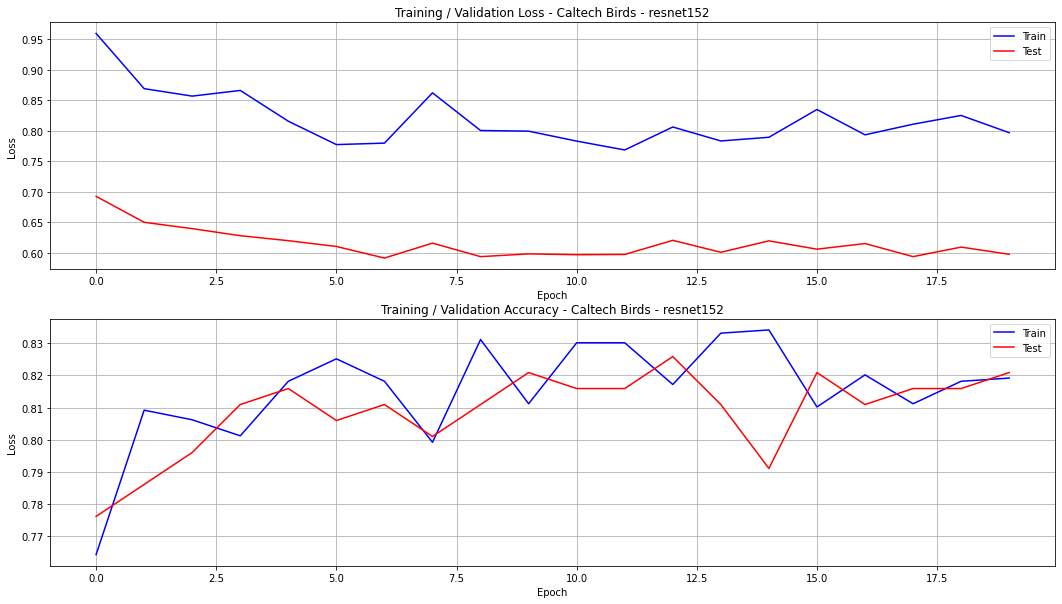

In [52]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model_name))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model_name))
plt.legend()

plt.show()

In [53]:
def save_model_dict(model, PATH):
    torch.save(model.state_dict(), PATH)

def save_model_full(model, PATH):
    torch.save(model, PATH)

In [60]:
save_model_full(model=model_ft, PATH=os.path.join(root_dir, 'trainedModel.pth'))
save_model_dict(model=model_ft, PATH=os.path.join(root_dir, 'trainedModelDict.pth'))

## Testing

In [98]:
def visualize_model_grid(model, class_names, device, dataloaders, num_images=6, figsize=(20,20), images_per_row=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=figsize)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                
                ax = plt.subplot(num_images//images_per_row, images_per_row, images_so_far)
                ax.axis('off')
                plt.imshow(inp)
                
                if labels[j] == preds[j]:
                    predict_statement = 'Predicted Right :)'
                else:
                    predict_statement = 'Predicted Wrong!!!'
                
                plt.title('{} \n Actual: {} \n Predicted: {}'.format(predict_statement, class_names[labels[j]], class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
model_file = os.path.join(root_dir, 'trainedModel.pth')

In [7]:
trainedModel = torch.load(model_file)

In [ ]:
visualize_model_grid(model=trainedModel, class_names=target_names, device=device, dataloaders=dataloaders, num_images=12, figsize=(18,25))

In [8]:
preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

In [105]:
from IPython.display import Image 
test_img = Image(filename='/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images/test/004.Groove_billed_Ani/Groove_Billed_Ani_0078_1780.jpg')

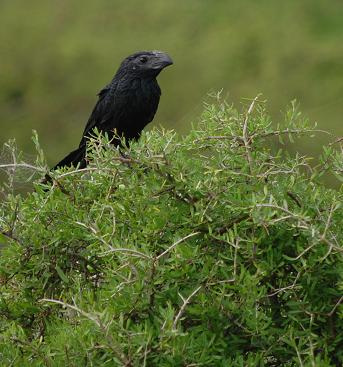

In [106]:
display(test_img)

In [9]:
from PIL import Image 
test_img = Image.open('/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/new_images/test/004.Groove_billed_Ani/Groove_Billed_Ani_0078_1780.jpg')

In [10]:
input = preprocess(test_img).unsqueeze_(0)

In [11]:
trainedModel.eval()
input = input.cuda()
outputs = trainedModel(input)
_, preds = torch.max(outputs, 1)

In [12]:
p = preds.cpu().numpy()

In [13]:
p[0]

3

In [28]:
birds_protected_status = pd.read_csv('/content/drive/My Drive/ZooHackathon/CUB_200_2011/CUB_200_2011/Birds.csv', delimiter=';')

In [29]:
dict = {
    0 : 'Unprotected',
    1 : 'Protected',
    2 : 'Nearly Protected'
}

In [30]:
birds_protected_status.head()

,Name,Protected
0,Black_footed_Albatross,2
1,Laysan_Albatross,2
2,Sooty_Albatross,1
3,Groove_billed_Ani,0
4,Crested_Auklet,0


In [33]:
print(dict[birds_protected_status.iloc[1]['Protected']])

Nearly Protected


In [32]:
birds_protected_status.iloc[1]['Protected']

2

In [111]:
outputs

tensor([[-1.2228, -1.4365, -0.8549,  6.5717, -0.2216, -1.5074, -1.7503, -0.7747,
          1.0003, -0.2005, -0.5685, -0.1178,  1.2888, -0.5714, -2.2428, -1.7055,
         -1.3089, -1.1204, -0.2946, -2.0751, -1.2743, -0.6753,  0.5273,  0.7880,
          1.3897,  2.1874,  1.6679, -0.7066,  1.6243,  2.7008, -0.1968, -0.1979,
         -0.8391, -1.0824]], device='cuda:0', grad_fn=<AddmmBackward>)

In [142]:
minv = torch.min(outputs)

In [143]:
minv

tensor(-2.2428, device='cuda:0', grad_fn=<MinBackward1>)

In [150]:
new_tensor = np.full((1, 34), minv.detach().cpu())

In [151]:
new_tensor

array([[-2.2427819, -2.2427819, -2.2427819, -2.2427819, -2.2427819,
        -2.2427819, -2.2427819, -2.2427819, -2.2427819, -2.2427819,
        -2.2427819, -2.2427819, -2.2427819, -2.2427819, -2.2427819,
        -2.2427819, -2.2427819, -2.2427819, -2.2427819, -2.2427819,
        -2.2427819, -2.2427819, -2.2427819, -2.2427819, -2.2427819,
        -2.2427819, -2.2427819, -2.2427819, -2.2427819, -2.2427819,
        -2.2427819, -2.2427819, -2.2427819, -2.2427819]], dtype=float32)

In [152]:
 new_tensor = torch.from_numpy(new_tensor)

In [156]:
probs = torch.subtract(outputs.detach().cpu(), new_tensor)

In [157]:
probs

tensor([[1.0200, 0.8063, 1.3878, 8.8145, 2.0211, 0.7354, 0.4925, 1.4681, 3.2431,
         2.0423, 1.6743, 2.1250, 3.5316, 1.6714, 0.0000, 0.5372, 0.9339, 1.1224,
         1.9482, 0.1677, 0.9684, 1.5675, 2.7701, 3.0308, 3.6325, 4.4302, 3.9107,
         1.5362, 3.8671, 4.9436, 2.0459, 2.0449, 1.4037, 1.1604]])

In [159]:
sumv = torch.sum(probs)

In [1]:
sumv

NameError: ignored